V.1  Exploring the green reds

A) Plot Scatter Matrix

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from matplotlib.collections import LineCollection
import pandas
import numpy as np
import matplotlib
import matplotlib.patches as patches

def main():
    file = "winequality-red.csv"
    download = pandas.read_csv(file,  sep=';')
    plot_scatter_matrix(download, 6, 5, save_plot=False)

def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    red_wine = wine_data
    numvars, numdata = red_wine.shape
    fig, axes = plt.subplots(numdata-1, numdata-1, figsize=(40, 40))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    for i in range((numdata) - 1):
        for j in range((numdata) - 1):
            if (i == j):
                axes[i, j].text(0.5, 0.5, red_wine.columns[i], fontsize=20, ha='center')
            else:
                colors = []
                for k in red_wine['quality']:
                #identify color for specific dot on map
                    if k >= good_threshold:
                        colors.append('blue')
                    elif k <= bad_threshold:
                        colors.append('red')
                    else:
                        colors.append('white')
                size = [10 if k >= good_threshold else 10 if k <= bad_threshold else 0 for k in red_wine['quality']]
                #if wine quality not in range we make size of dot = 0
                axes[i, j].scatter(red_wine[red_wine.columns[i]], red_wine[red_wine.columns[j]], c=colors, s=size)
                #prints graph by square
    if (save_plot == True):
        plt.savefig('figure.png')
    else:
        plt.show()

main()

<Figure size 4000x4000 with 121 Axes>

B) I think pH, sulphates and alcohol will be most useful factors to my perceptron for distinguishing highquality vs. low quality wines, because on graph above, these factors have more variation than other factors.

V.2 Learning to perceptron

a) Implement a perceptron with random weights and bias and use Rosenblatt perceptron learning rule, and utilizes the heaviside step activation function

In [2]:
def inf_num():
    i = 0
    while True:
        yield i
        i += 1
        
def dot_product(X, w):
    ret = 0
    for i in range(len(w)):
        ret += X[i] * w[i]
    return (ret)

In [3]:
class Perceptron():
    def __init__(self, thresholds=0.0, learning_rate=0.01, epochs=10):
        self.thresholds = thresholds
        self.learning_rate = learning_rate
        self.epochs = epochs
    
    def fit(self, X, y):
        # randomly initialized weights(w[1:]) and bias(w[0])
        random.seed(3003)
        self.w = [random.random()] * (1 + X.shape[1])
        ret = []
        
        # Rosenblatt perceptron learning rule (adjusting slope of line)
        for i in range(self.epochs) if self.epochs != 0 else inf_num():
            errors = 0
            for xi, target in zip(X, y):
                update = self.learning_rate * (target - self.predict(xi))
                self.w[1:] += update * xi
                self.w[0] += update
                errors += int(update != 0.0)
            ret.append((i, errors, self.w[1:], self.w[0]))
            if (errors == 0 and self.epochs == 0):
                break
        
        return (ret)
    
    def net_input(self, X):
        return (dot_product(X, self.w[1:]) + self.w[0])
    
    def predict(self, X):
        return (1 if self.net_input(X) > self.thresholds else -1)

In [4]:
def GetNewQuality(data, good_threshold, bad_threshold):
    #we make quality field for our data
    exp = []
    for i in data['quality']:
        if i >= good_threshold:
            exp.append(1)
        elif i <= bad_threshold:
            exp.append(-1)
        else:
            exp.append(0)
    return (exp)

In [5]:
def find_min_max(max_, data):
    ret = data[0]
    if max_ == 0:
        for val in data:
            if val < ret:
                ret = val
    else:
        for val in data:
            if val > ret:
                ret = val
    return (ret)

def plot_performance(performance, wine_data, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    errors = []
    for t in performance:
        errors.append(t[1])
    if (epoch < 0):
        tup = performance[len(performance) - 1]
    else:
        tup = performance[epoch]
        
    y_min = find_min_max(0, wine_data[wine_data.columns[0]].values)
    y_max = find_min_max(1, wine_data[wine_data.columns[0]].values)    
    x_min = find_min_max(0, wine_data[wine_data.columns[1]].values)
    x_max = find_min_max(1, wine_data[wine_data.columns[1]].values)
    
    wine_data0 = wine_data[wine_data['quality'] < good_thresh]
    wine_data1 = wine_data[wine_data['quality'] >= good_thresh]
    
    y = [0] * 11
    x = [0] * 11
    
    slope = -(tup[3]/tup[2][0])/(tup[3]/tup[2][1])
    intercept = -tup[3]/tup[2][0]
    k = 0
    for i in range(11):
        x[i] = k + x_min
        y[i] = slope * x[i] + intercept
        k += (x_max - x_min) / 10

    #print errors graph
    fg = plt.figure(figsize=(20, 5))
    ax1 = fg.add_subplot(121)
    ax2 = fg.add_subplot(122)
    ax1.plot(range(0, performance[len(performance) - 1][0]), errors[1:])
    ax1.set_title("Errors as a function of epoch")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("classification errors")
    
    #print dots graph
    #print division line
    ax2.plot(x, y, label="Decision Boundary")
    #fix line position
    ax2.axis([x_min, x_max, y_min, y_max])
    #fill halfs red and blue
    ax2.fill_between(x, y, y_min - 2, where = y > y_min - 2, facecolor='blue', alpha=.2)
    ax2.fill_between(x, y, y_max + 2, where = y < y_max + 2, facecolor='red', alpha=.2)
    #print dots
    ax2.scatter(wine_data0[wine_data0.columns[1]], wine_data0[wine_data0.columns[0]], c='red', label='bad wines(<{0} score)'.format(bad_thresh + 1), s=20)
    ax2.scatter(wine_data1[wine_data1.columns[1]], wine_data1[wine_data1.columns[0]], c='blue', label='good wines(>{0} score)'.format(good_thresh -1), s=20)
    ax2.set_title("Decision boundary on epoch: {0}".format(tup[0]))
    #left and down labels
    ax2.set_xlabel(wine_data.columns[1])
    ax2.set_ylabel(wine_data.columns[0])
    #inf box on right side
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()
    if (save_plot == True):
        plt.savefig('plot_performance.png')
    else:
        plt.show()

-----------------
[-145.462120366454, 34.63587963362288]


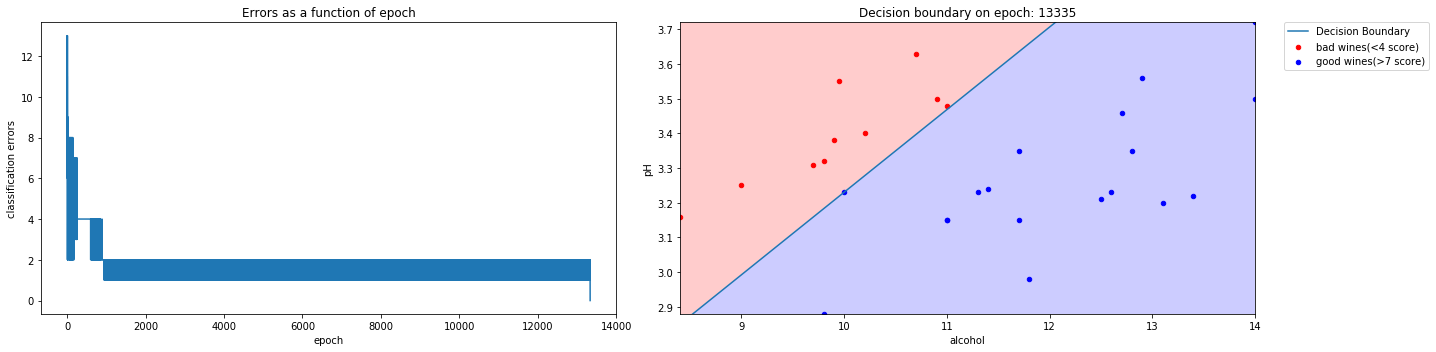

In [11]:
import random

def simple_perceptron():
    #removing extra data
    file = "winequality-red.csv"
    download = pandas.read_csv(file,  sep=';')
    download = download[(download.quality >= 8) | (download.quality <= 3)]
    new_quality = GetNewQuality(download, 8, 3)
#     print(download.quality.values)
#     print(new_quality)

    # randomly initialized weights(w[1:]) and bias(w[0])
    random.seed(3003)
    weights = [random.random()] * (1 + download.shape[1])

    download = download[['pH', 'alcohol']].values
    ppn1 = Perceptron(epochs=0, learning_rate = 0.1)
    new_weights = ppn1.fit(download, new_quality)


    print("-----------------")
#     print(new_weights)
    download = pandas.read_csv(file,  sep=';')
    download = download[(download.quality >= 8) | (download.quality <= 3)]
    print(new_weights[len(new_weights) - 1][2])
    plot_performance(new_weights, download[['pH', 'alcohol', 'quality']], 8, 3)
    
simple_perceptron()

d) learning more efficiently! Feature Scaling formula: x' = (current_x - min(x)) / max(x) - min(x)

-----------------
[-0.9465013187578809, 1.0987367764802134]


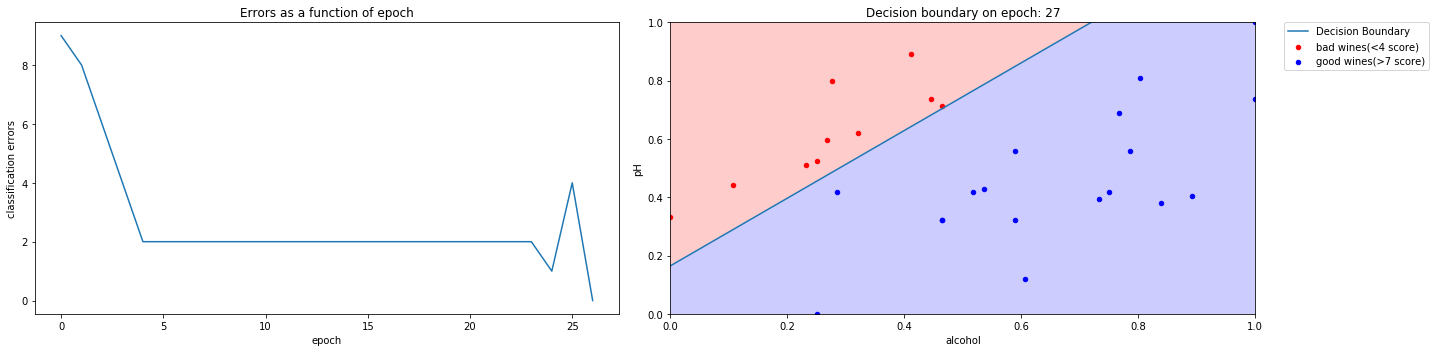

In [12]:
def normilized_perceptron():
    #removing extra data
    file = "winequality-red.csv"
    download = pandas.read_csv(file,  sep=';')
    download = download[(download.quality >= 8) | (download.quality <= 3)]
    new_quality = GetNewQuality(download, 8, 3)
#     print(download.quality.values)
#     print(new_quality)
    
    tmp = download[['pH', 'alcohol', 'quality']]
    download = download[['pH', 'alcohol']].values
    x_min = find_min_max(0, tmp['pH'].values)
    x_max = find_min_max(1, tmp['pH'].values)
    y_min = find_min_max(0, tmp['alcohol'].values)
    y_max = find_min_max(1, tmp['alcohol'].values)
    
    for i in range(len(download)):
        download[i][0] = (download[i][0] - x_min) / (x_max - x_min)
        download[i][1] = (download[i][1] - y_min) / (y_max - y_min)
        tmp['pH'].values[i] = download[i][0]
        tmp['alcohol'].values[i] = download[i][1]
    
    ppn1 = Perceptron(epochs=0, learning_rate = 0.1)
    new_weights = ppn1.fit(download, new_quality)


    print("-----------------")
#     print(new_weights)
    download = pandas.read_csv(file,  sep=';')
    download = download[(download.quality >= 8) | (download.quality <= 3)]
    print(new_weights[len(new_weights) - 1][2])
    plot_performance(new_weights, tmp[['pH', 'alcohol', 'quality']], 8, 3)

normilized_perceptron()